## 14-3장. 데이터 분석 예제 - US Baby Names

In [1]:
import numpy as np
import pandas as pd 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style='whitegrid', palette="pastel")

import warnings
warnings.filterwarnings("ignore")

- 미국 사회보장국(SSA)이 집계한 신생아 이름 데이터 (1980~2018년) 
- *source : https://www.ssa.gov/oact/babynames/limits.html
- columns :  name, sex(M/F), numbers 
- No header, txt files, seperator = , 

In [2]:
names1880 = pd.read_csv('datasets/babynames/yob1880.txt', names = ['name', 'sex', 'numbers'])
names1880

,name,sex,numbers
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


In [3]:
print( '1880년의 총 출생자 수 = ',  names1880['numbers'].sum() )
print('-----------------------------------------------------------')
print( '1880년의 남여 출생 수는? ',  names1880.groupby('sex')['numbers'].sum())

1880년의 총 출생자 수 =  201484
-----------------------------------------------------------
1880년의 남여 출생 수는?  sex
F     90994
M    110490
Name: numbers, dtype: int64


In [4]:
#### 1880~2018년 자료를 pd.concat으로 합치기 

years = range(1880, 2019)                 ## 2010년이 마지막이므로 2011로 설정 
columns = ['name', 'sex', 'numbers']      ## 컬럼명 지정 
datasets = []                             ## 임시로 데이터들을 담아놓을 빈 리스트 

for year in years : 
    path = 'datasets/babynames/yob%d.txt'  %year
    frame = pd.read_csv(path, names = columns)
    frame['year'] = year
    datasets.append(frame)
    
all_names = pd.concat(datasets, ignore_index = True)

In [5]:
print( all_names.shape )
all_names.tail()

(1957046, 4)


,name,sex,numbers,year
1957041,Zylas,M,5,2018
1957042,Zyran,M,5,2018
1957043,Zyrie,M,5,2018
1957044,Zyron,M,5,2018
1957045,Zzyzx,M,5,2018


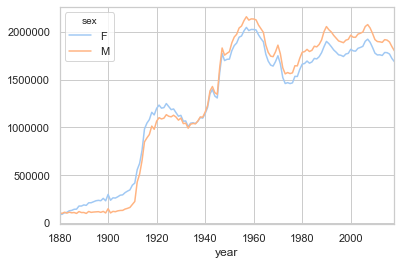

In [6]:
#### 피봇 테이블을 만들고, 차트로 표현하기 
t = all_names.pivot_table('numbers', index = 'year', columns = 'sex', aggfunc = sum)
t.plot()

In [7]:
#### 각 이름이 전체에서 차지하는 비중 구하여, 컬럼으로 추가하기 
def add_group(group) : 
    group['prob'] = group.numbers / group.numbers.sum()
    return group 

all_names = all_names.groupby(['year', 'sex']).apply(add_group)

In [8]:
print( all_names.shape)
all_names.head()

(1957046, 5)


,name,sex,numbers,year,prob
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


In [9]:
#### 각 연도의 성별 비중의 합이 1이 맞는지 확인 
all_names.groupby(['year', 'sex']).prob.sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2016  M      1.0
2017  F      1.0
      M      1.0
2018  F      1.0
      M      1.0
Name: prob, Length: 278, dtype: float64

In [10]:
#################################################################
########### 1. 가장 흔한 이름들의 연도별 트렌드는? 
#################################################################

In [46]:
#### 가장 흔한 이름 top 5 구하기 
pop_names = all_names.groupby('name').prob.sum()
pop_names = pd.DataFrame(pop_names)
pop_names = pop_names.sort_values(by='prob', ascending = False) 
pop_names.head()

,prob
name,
John,5.634711
James,4.867995
Mary,4.768006
William,4.733988
Robert,4.014723


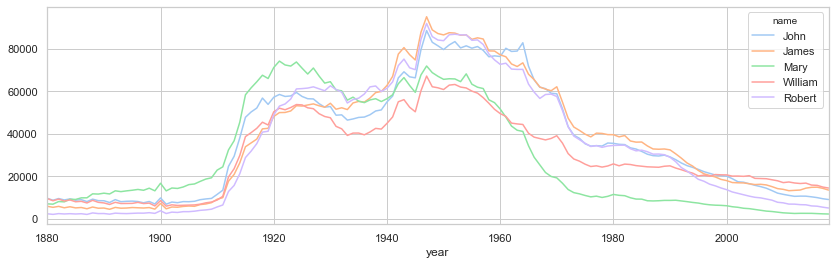

In [47]:
all_names_pivot = all_names.pivot_table('numbers', index = 'year', columns = 'name', aggfunc = sum)
subset = all_names_pivot[['John', 'James', 'Mary', 'William', 'Robert']]
subset.plot(figsize = (14,4))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2118846A0>,
      dtype=object)

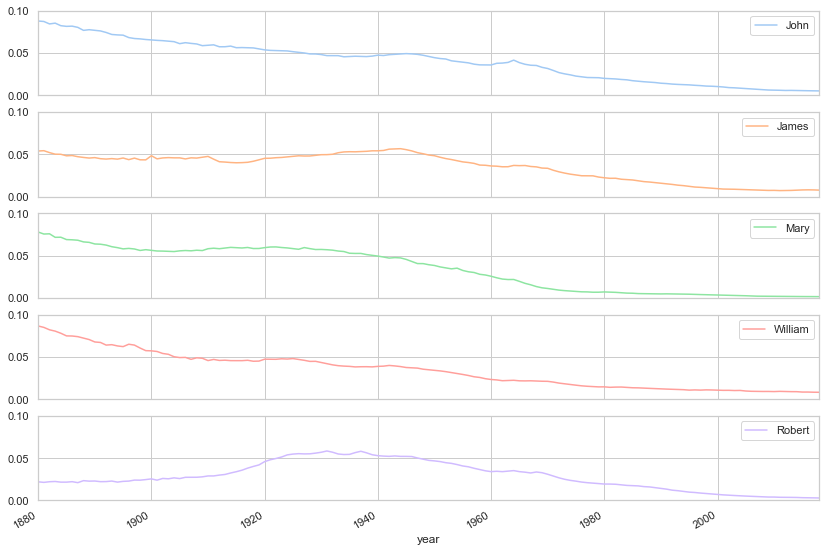

In [60]:
all_names_pivot2 = all_names.pivot_table('prob', index = 'year', columns = 'name', aggfunc = sum)
subset2 = all_names_pivot2[['John', 'James', 'Mary', 'William', 'Robert']]
subset2.plot(subplots = True,  figsize = (14,10), ylim=(0, 0.1) )           ## subplots 활성화, y축 범위(ylim) 고정 

- 흔한 이름들의 비중이 점차 줄어드는 추세임 

In [14]:
#################################################################
########### 2. 연도별 상위 10%에 속하는 이름의 가짓수를 구하라 
#################################################################

In [15]:
def get_count(group, q=0.1) : 
    group = group.sort_values(by = 'prob', ascending = False)
    return group.prob.cumsum().values.searchsorted(q)+1    ### index가 0부터 시작하므로, q+1

name_count = all_names.groupby(['year', 'sex']).apply(get_count)
name_count

year  sex
1880  F       2
      M       2
1881  F       2
      M       2
1882  F       2
             ..
2016  M      13
2017  F      13
      M      13
2018  F      14
      M      14
Length: 278, dtype: int64

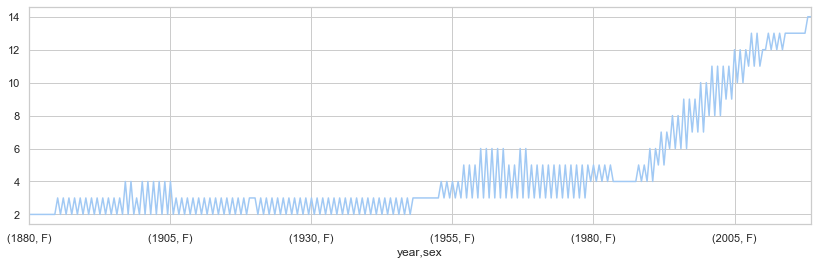

In [16]:
name_count.plot(figsize = (14,4))   #### 남여의 구분이 되지 않는다 --> unstack 

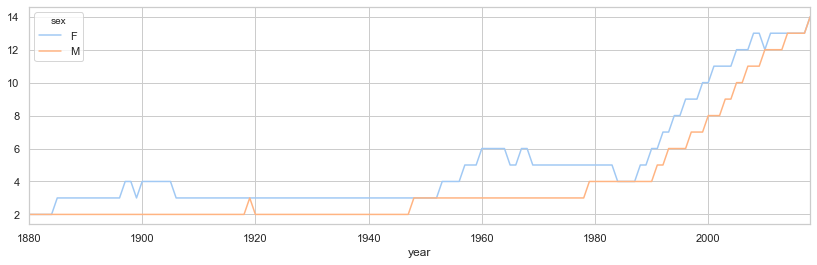

In [17]:
name_count2 = name_count.unstack('sex')
name_count2.plot( figsize = (14,4) )

- 최근에 가까와 질수록 top 10%에 속하는 이름의 가짓수가 계속 증가하고 있다. 